# 06. PyTorch Transfer Learning

Transfer Learning envolve pegar os parâmetros de um um modelo treinado e o aplicar em outro modelo.

Também é possível ver o termo `foundation models`

In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu118
0.15.2+cu118


Vamos importar o código que já escrevemos em seções passadas para não ter que escrever tudo de novo.

In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/data .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3849, done.
remote: Counting objects: 100% (3849/3849), done.
remote: Compressing objects: 100% (1571/1571), done.
remote: Total 3849 (delta 2255), reused 3753 (delta 2217), pack-reused 0
Receiving objects: 100% (3849/3849), 647.06 MiB | 39.65 MiB/s, done.
Resolving deltas: 100% (2255/2255), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
!nvidia-smi

Fri Jul 21 21:35:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1. Conseguindo os dados

Precisamos dos dados para construir o nosso modelo. Já baixamos eles quando clonamos o repositório.

In [5]:
from pathlib import Path
import zipfile
import os

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

# Remove .zip file
os.remove(data_path / "pizza_steak_sushi.zip")

train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

Unzipping pizza, steak, sushi data...


(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Criando Datasets e DataLoders

Queremos tornar os dados em PyTorch DataLoaders.

Para fazer isso, podemos usar o código desenvolvido na seção 05. Pytorch Going Modular dentro do arquivo `data_setup.py`.

Uma coisa que precisamos pensar é em como transformar os dados.

Com `torchvision` 0.13+, existem duas maneiras de fazer isso:

1. Transforms criados manualmente (definido por mim)
2. Transforms criados automaticamente (definido pelo modelo que queremos usar)

Importante: Ao usar um modelo pré-treinado, é importante que os dados utilizados sejam transformados do mesmo jeito que o modelo carregado foi treinado.


### 2.1 Criando um transform com `torchvision.models` (criação manual)

Esse pacote possui modelos pré-treinados (prontos para transfer learning) dentro de `torchvision`

In [6]:
from torchvision import transforms

#Para que os dados fiquem na mesma distribuição dos dados em que
#o modelo foi treinado. Esses valores podem ser calculados
#sobre o dataset ou ver a documentação do PyTorch 0.13-
#para o modelo a ser carregado mais a frente
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize])

In [7]:
from going_modular.going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir, test_dir, manual_transforms, batch_size=32,
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7cb7b2037760>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Criando um transform com `torchvision.models` (criação automática)

Com `torchvision` v0.13+, agora existe apoio para criação de transforms de dados automática baseado no modelo pré-treinado a ser usado

In [8]:
# Consegue um conjunto de pesos de um modelo pré-treinado
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT #Melhor disponível
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [9]:
# Consegue os transforms usados
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [10]:
# Cria DataLoaders usando os transforms automáticos
train_dataloader, test_dataloader, calss_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=auto_transforms,
    batch_size=32
)
train_dataloader, test_dataloader, calss_names

(<torch.utils.data.dataloader.DataLoader at 0x7cb7b1f3bc40>,
 ['pizza', 'steak', 'sushi'])

## 3. Conseguindo um modelo pré-treinado

Existem muitos lugares para conseguir um modelo pré-treinado tais como:
1. PyTorch
2. Bibliotecas como `timm` (torch image models)
3. HuggingFace hub
4. Paperswithcode

### 3.1 Qual modelo pré-treinado você deve usar?

*Experimente, experimente, experimente*

A ideia de transfer learning é pegar um modelo treinado com boa performance em um problema similar ao seu e então o alterar para o problema alvo.

Coisas a considerar:
1. Velocidade - Quão rápido o modelo roda (geralmente, menos parâmetros significa mais velocidade)
2. Tamanho - Quão grande é o modelo
3. Performance - Quão bem o modelo vai no problema alvo

Onde o modelo vive?

É no próprio device (como em um carro que dirige sozinho)

Ou ele está em um servidor?

Analisando https://pytorch.org/vision/stable/models.html#table-of-all-available-classification-weights, qual modelo devemos escolher?

No nosso caso, realizar o deploy do modelo para o serviço FoodVision, Mini EffNetB0 é uma boa opção.

Entretanto, se tivéssemos computação infinita, escolheríamos o maior modelo possível. (http://www.incompleteideas.net/IncIdeas/BitterLesson.html)


### 3.2 Configurando um modelo pré-treinado

Queremos criar uma instância já treinada do EffNetB0.

https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b0.html#torchvision.models.efficientnet_b0



In [11]:
# Método antigo de criar um modelo pré-treinado (antes do torchvision v0.13)

model = torchvision.models.efficientnet_b0(pretrained=True)

# Novo método para criar um modelo pré-treinado (torchvision v0.13+)

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 138MB/s] 


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [12]:
# Camada de extração de features (está nomeada no modelo)
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [13]:
# Camada de avgpool (nomeado no modelo)
model.avgpool

AdaptiveAvgPool2d(output_size=1)

In [14]:
# Camada de classificação (nomeado no modelo)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

Ele prevê 1000 classes. Como só temos 3 classes, teremos que alterar isso.

Existem dois tipos de transfer learning.

1. (Feature extraction) Se temos poucos dados disponíveis para o nosso problema, mantemos as camadas de extração de features constantes e alteramos apenas o head, no caso, de classificação.
2. (Fine-tuning) Se temos bastante dados disponíveis, podemos treinar algumas das últimas camadas do extrator de features além do head de classificação.



### 3.3 Conseguindo um resumo do nosso modelo com `torchinfo.summary()`



In [15]:
from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 224, 224), #exemplo de [batch_size, n_channels, height, width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

Podemos ver quantos parâmetros existem em cada camada, se a camada está no modo treinável, os shapes dos dados e o tamanho (estimado) do modelo em memória.

### 3.4 Congelando o modelo base e alterando a camada de saída

Com um modelo de extração de features, tipicamente, iremos "congelar" as camadas base de um modelo pré-treinado e atualizar as camadas de saída pra se ajustar ao problema atual.

In [16]:
# Congela as camadas bases
for param in model.features.parameters():
  param.requires_grad = False

In [17]:
summary(model=model,
        input_size=(1, 3, 224, 224), #exemplo de [batch_size, n_channels, height, width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

Agora, as primeiras camadas estão congeladas. Apenas 1.281 milhão dos 5.288 milhões dos parâmetros serão treinados.

In [18]:
# Atualizando o classificador
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names))
).to(device)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [19]:
summary(model=model,
        input_size=(1, 3, 224, 224), #exemplo de [batch_size, n_channels, height, width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

Temos apenas cerca de 4 mil pesos treináveis.

## 4. Treinando o modelo

In [20]:
# Definindo um loss e otimizador
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
#Importando função de treino
from going_modular.going_modular import engine

torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

#Configura treinamento e salva resultados
results = engine.train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=25,
    device=device
)


end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0929 | train_acc: 0.4023 | test_loss: 0.9125 | test_acc: 0.5502
Epoch: 2 | train_loss: 0.8703 | train_acc: 0.7773 | test_loss: 0.7900 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.8008 | test_loss: 0.7433 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7114 | train_acc: 0.7578 | test_loss: 0.6344 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6252 | train_acc: 0.7930 | test_loss: 0.6238 | test_acc: 0.8864
Epoch: 6 | train_loss: 0.5770 | train_acc: 0.8984 | test_loss: 0.5715 | test_acc: 0.8759
Epoch: 7 | train_loss: 0.5259 | train_acc: 0.9141 | test_loss: 0.5457 | test_acc: 0.8759
Epoch: 8 | train_loss: 0.5250 | train_acc: 0.8047 | test_loss: 0.5300 | test_acc: 0.8769
Epoch: 9 | train_loss: 0.5667 | train_acc: 0.8125 | test_loss: 0.5080 | test_acc: 0.8456
Epoch: 10 | train_loss: 0.4847 | train_acc: 0.8164 | test_loss: 0.4390 | test_acc: 0.9062
Epoch: 11 | train_loss: 0.4315 | train_acc: 0.9336 | test_loss: 0.4617 | test_acc: 0.8759
Epoch: 12 | train_l

## 5. Avaliando o modelo ao plotar curvas de loss

In [22]:
try:
  from helper_functions import plot_loss_curves
except:

  print("[INFO] Não encontrou helper_functions.py, downloading...")
  with open("helper_functions.py", "wb") as f:
    import requests
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    f.write(request.content)

  from helper_functions import plot_loss_curves

[INFO] Não encontrou helper_functions.py, downloading...


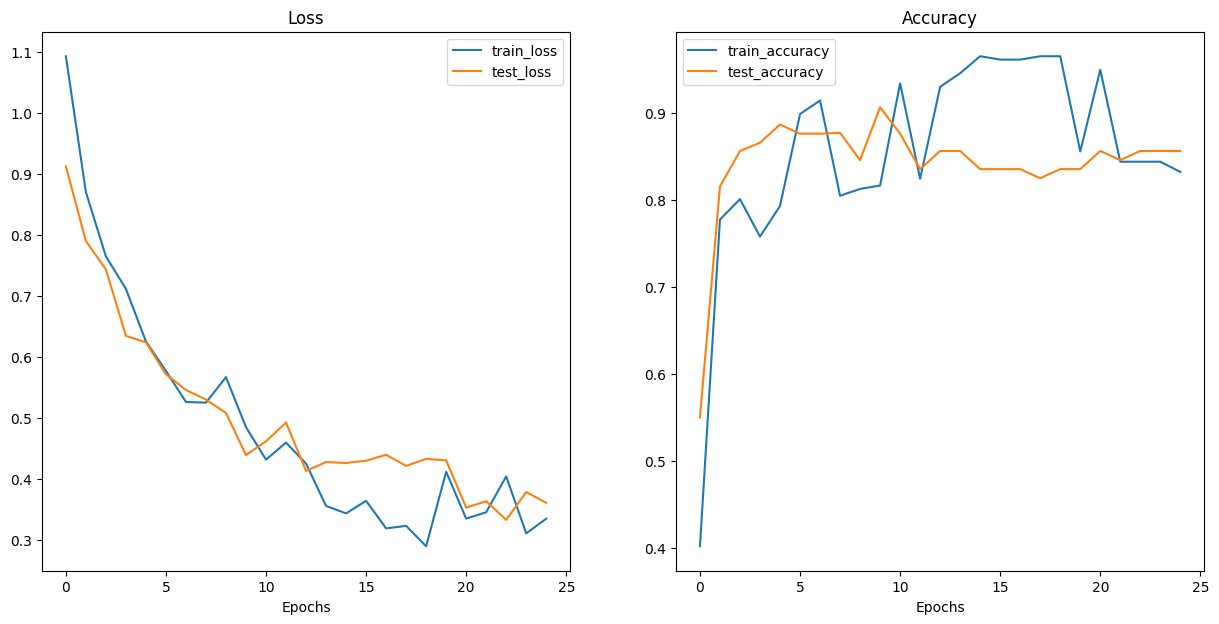

In [23]:
# Plotando as curvas de loss
plot_loss_curves(results)

Como as nossas curvas de loss se comparam às curvas ideais?

As curvas de loss parecem decrescer de forma suave, o que é bom. A loss de teste parece seguir o movimento da loss de treino até a iteração 12 e, depois, diverge por algum tempo. Na iteração 20, a loss de teste volta a seguir o movimento da loss de treino.

Ainda não é possível dizer, com confiança, que o modelo está overfittando, sendo necessárias mais épocas para avaliar.

Sobre a acurácia, a acurácia de teste parece ter se estabilizado ao redor de 0.85 a partir da época 10. Já a acurácia de treino continua um movimento de subida ao longo das épocas.

Olhando a acurácia, é possível dizer que com 15 iterações o modelo já está bom o suficiente.

## 6. Realizando predições em imagens do conjunto de teste

Vamos aderir ao lema do explorador de dados de *Visualizar, visualizar e visualizar*.

E fazer algumas predições qualitativas no conjunto de dados.

Algumas coisas que devemos levar em consideração:

* Mesmo shape: imagens precisam ser do mesmo shape que o modelo foi treinado
* Mesmo tipo de dados: dados precisam ser do mesmo tipo
* Mesmo device: os dados devem estar no mesmo device que o modelo
* Mesmo transform: Se transformamos os dados de treino, idealmente, devemos aplicar as mesmas transformações nos dados de teste

Para fazer tudo isso automagicamente, vamos criar uma função chamada `pred_and_plot_image()`:

A função será similar à função daqui: https://www.learnpytorch.io/04_pytorch_custom_datasets/#113-putting-custom-image-prediction-together-building-a-function

1. Recebemos um modelo treinado, uma lista de nomes de classes, um caminho para a imagem alvo, um tamanho da imagem, um transform e um device alvo
2. Abrir a imagem com `PIL.Image.Open()`
3. Criar um transform se ele não existir
4. Garantir que o modelo está no device alvo
5. Mudar o modelo para o modo de inferência com `model.eval()`
6. Transformar a imagem alvo e garantir que a sua dimensionalidade é ajustada para o modelo (lembrando da dimensão de batches)
7. Realizar uma predição sobre a imagem
8. Converter os logits de saída do modelo em probabilidades usando `torch.softmax()`
9. Converter as probabilidades de predição em labels com `torch.argmax()`
10. Plotar a imagem com `matplotlib` e definir o título com o nome da classe e a probabilidade.

In [35]:
from typing import List, Tuple

from PIL import Image

from torchvision import transforms

# Passo 1
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device = device
                        ):
  # Passo 2
  img = Image.open(image_path)

  # Passo 3
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])


  # Passo 4
  model.to(device)

  # Passo 5
  model.eval()
  with torch.inference_mode():
    # Passo 6
    transformed_image = image_transform(img).unsqueeze(dim=0)

    # Passo 7
    target_image_pred = model(transformed_image.to(device))

    # Passo 8
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Passo 9
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Passo 10
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")

    plt.axis(False);

[PosixPath('data/pizza_steak_sushi/test/steak/502076.jpg'), PosixPath('data/pizza_steak_sushi/test/pizza/416067.jpg'), PosixPath('data/pizza_steak_sushi/test/steak/1882831.jpg')]


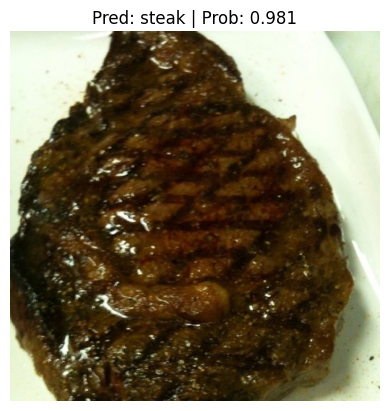

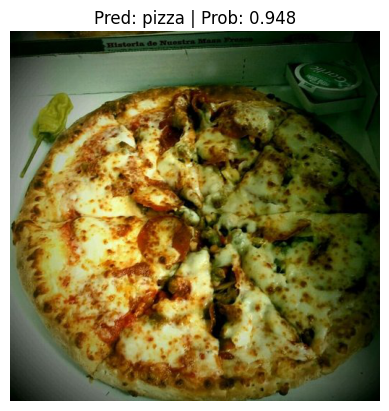

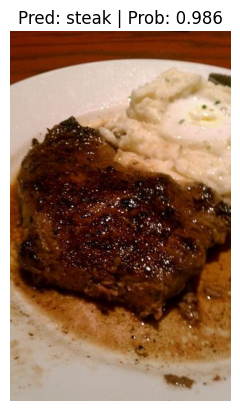

In [42]:
# Consegue uma lista aleatória de caminhos do conjunto de teste

import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)
print(test_image_path_sample)
for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(224, 224))